### Импорты

In [48]:
import pandas as pd
import numpy as np
import statistics as st
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None

Задачи такого плана обычно выполняю следующим образом:<br>
- строю множество элементов с завимостью одного параметра от другого (scatter plot). Параметры могут быть производными (например, метод синтетических цен)<br>
- аппроксимирую несколько типов функций с подбором коэффициентов<br>
- выбираю ту,  которая точее описыпает множество<br>

В текущем решении кратко продемострирую простой пример с линейной функцией<br> и метод с расчётом эластичности спроса (по описанию позиции от HR услышал, что данный метод актуален и важен)<br>

- В прод решении было бы интересно покрутить с применением метода опорных векторов (SVR)

### Задание 2 v1 - Линейная регрессия

#### Подготовка источников

In [32]:
# Загрузка цен
df_prices_base = pd.read_excel('Тестовое_задание_Data_аналитик_ЦО_2025_.xlsx', sheet_name = 'Данные для задачи 2' )
df_prices_base.columns = ['dt', 'item_id', 'sales', 'price_wo_disc', 'price_w_disc']
df_prices_base['price_w_disc'] = df_prices_base['price_w_disc'].round(2)
df_prices_base['disc'] = df_prices_base.apply(lambda x: round((x.price_wo_disc- x.price_w_disc) / x.price_wo_disc, 4), axis = 1 )

#### Группировка данных в массивы

In [102]:
# Упаковываю в массивы, чтобы построчно работать
df_prices_gr = (df_prices_base.groupby(['item_id'], as_index = False)
                .agg(sales = ('sales', lambda x: x.to_list() )
                     , price_wo_disc = ('price_wo_disc', lambda x: x.to_list() )
                     , price_w_disc = ('price_w_disc', lambda x: x.to_list() )
                     , disc = ('disc', lambda x: x.to_list() )
                    )
               )

#### Моделирование и расчёт целевых скидок

На практие лично мне оказался удобен и производителен такой метод с одновременным построением простых моделей (с небольшим кол-вом входных ланных ) прямо в ячейках Pandas DF

In [143]:
MAX_DISC = 0.5 # Задаю максимальную допустимую скидку, для примера пусть 50% будет
GROWTH = 2 # Целевой рост продаж

# Обучение модели в на своих массивах в каждой строке
df_prices_gr['model_linear'] = df_prices_gr.apply(lambda x: LinearRegression().fit(np.array(x.disc).reshape(-1, 1), np.array(x.sales) ), axis = 1 ) 

# Равномерный диапазон скидок для дальнейшего подбора от 0 до MAX_DISC
df_prices_gr['disc_arr'] = df_prices_gr.apply(lambda x: np.linspace(0, MAX_DISC, 100 ), axis = 1 ) # np.array(x.disc).max() +

# По массиву disc_arr находим соответ ствующее ему множество прогнозных объёмов продаж по модели
df_prices_gr['predicted_sales'] = df_prices_gr.apply(lambda x: x.model_linear.predict(x.disc_arr.reshape(-1, 1) ), axis = 1 )

# Оределяем текущий объём продаж как среднее кол-во продаж за период (получается, что это с учётом кол-ва дней, скидок в эти дни и тд)
df_prices_gr['current_sales'] = df_prices_gr.apply(lambda x: st.mean(x.sales), axis = 1 )

# Находим пересечение множеств скидок и объёмов на целевом объёме
df_prices_gr['rec_discount'] = df_prices_gr.apply(lambda x: x.disc_arr[x.predicted_sales >= x.current_sales * GROWTH][0] 
                                                  if len(x.disc_arr[x.predicted_sales >= x.current_sales * GROWTH]) > 0
                                                  else 0, axis = 1 )

df_prices_gr['rec_discount_txt'] = df_prices_gr['rec_discount'].apply(lambda x: f'{round(x * 100, 2)} %' )

df_prices_gr.head(3)

,item_id,sales,price_wo_disc,price_w_disc,disc,model_linear,disc_arr,predicted_sales,current_sales,rec_discount,rec_discount_txt
0,3226300004,"[9, 15, 12, 17, 13, 18, 7, 9, 12, 6, 8, 12, 5,...","[271, 271, 271, 271, 271, 271, 271, 271, 271, ...","[271.0, 271.0, 216.8, 216.8, 216.8, 216.8, 271...","[0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, ...",LinearRegression(),"[0.0, 0.005050505050505051, 0.0101010101010101...","[10.070029970029974, 10.338491306673129, 10.60...",13.032787,0.303030,30.3 %
1,3234800007,"[7, 6, 18, 16, 13, 18, 5, 9, 15, 11, 13, 13, 1...","[346, 346, 346, 346, 346, 346, 346, 346, 346, ...","[346.0, 346.0, 311.4, 311.4, 311.4, 311.4, 346...","[0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, ...",LinearRegression(),"[0.0, 0.005050505050505051, 0.0101010101010101...","[10.117860703603476, 10.409313185983176, 10.70...",12.672131,0.267677,26.77 %
2,14011400047,"[9, 11, 23, 27, 20, 28, 14, 10, 15, 13, 36, 30...","[1630, 1630, 1630, 1630, 1630, 1630, 1630, 163...","[1630.0, 1630.0, 1141.0, 1141.0, 1141.0, 1141....","[0.0, 0.0, 0.3, 0.3, 0.3, 0.3, 0.0, 0.0, 0.0, ...",LinearRegression(),"[0.0, 0.005050505050505051, 0.0101010101010101...","[9.98016775103865, 10.275699695077297, 10.5712...",13.721311,0.303030,30.3 %


#### Итоговый справочник скидок

In [148]:
dict_target_discounts = df_prices_gr.set_index('item_id')['rec_discount_txt'].to_dict()
dict_target_discounts

{3226300004: '30.3 %',
 3234800007: '26.77 %',
 14011400047: '30.3 %',
 14012900005: '26.26 %',
 15110900016: '32.32 %',
 15111300006: '22.73 %',
 15111300017: '21.72 %',
 19000000363: '28.28 %',
 19000013047: '29.29 %',
 19760336592: '31.31 %'}

#### Визуализация для примера

In [110]:
ITEM_ID = 19760336592

discounts = df_prices_gr.loc[df_prices_gr.item_id == ITEM_ID ]['disc_arr'].reset_index(drop=True)[0]
predicted_sales = df_prices_gr.loc[df_prices_gr.item_id == ITEM_ID ]['predicted_sales'].reset_index(drop=True)[0]
target_sales = df_prices_gr.loc[df_prices_gr.item_id == ITEM_ID ]['current_sales'].reset_index(drop=True)[0] * 2
recommended_discount = df_prices_gr.loc[df_prices_gr.item_id == ITEM_ID ]['rec_discount'].reset_index(drop=True)[0]

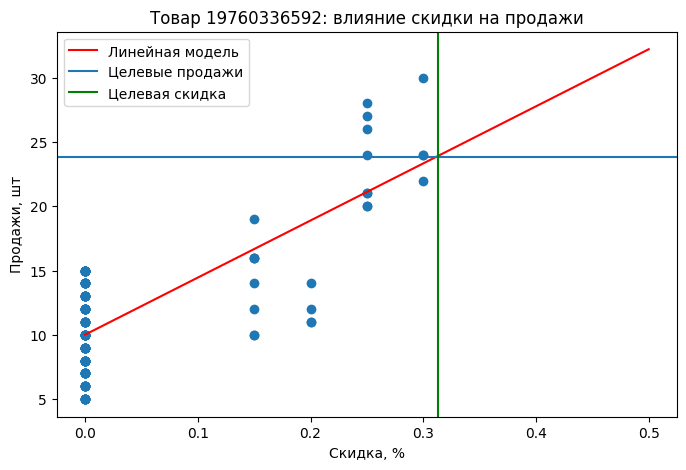

In [120]:
plt.figure(figsize = (8, 5))
plt.scatter(data['disc'], y)
plt.plot(discounts, predicted_sales, label = 'Линейная модель', color = 'red')
plt.axhline(target_sales, label = 'Целевые продажи' )
plt.axvline(recommended_discount, label = 'Целевая скидка', color = 'green' )
plt.xlabel("Скидка, %")
plt.ylabel("Продажи, шт")
plt.title(f"Товар {ITEM_ID}: влияние скидки на продажи")

plt.legend()
plt.show()

### Задание 2 v2 - Эластичность спроса

$$
k = \frac{\frac{Q_{\text{disc}} - Q_{\text{full}}}{Q_{\text{full}}}}
        {\frac{P_{\text{disc}} - P_{\text{full}}}{P_{\text{full}}}}
$$

In [145]:
df_for_elastic = df_prices_gr[['item_id', 'sales', 'price_wo_disc', 'price_w_disc', 'disc']].copy()

# Средняя продажа без скидки
df_for_elastic['avg_sale_wo_disc'] = df_for_elastic.apply(lambda x: st.mean([i for i, disc in zip(x.sales, x.disc) if disc == 0]), axis = 1 )

# Средняя продажа со скидкой
df_for_elastic['avg_sale_w_disc'] = df_for_elastic.apply(lambda x: st.mean([i for i, disc in zip(x.sales, x.disc) if disc != 0]), axis = 1 )

# Средняя цена без скидки
df_for_elastic['avg_price_wo_disc'] = df_for_elastic.apply(lambda x: st.mean([i for i, disc in zip(x.price_w_disc, x.disc) if disc == 0]), axis = 1 )

# Средняя цена со скидкой
df_for_elastic['avg_price_w_disc'] = df_for_elastic.apply(lambda x: st.mean([i for i, disc in zip(x.price_w_disc, x.disc) if disc != 0]), axis = 1 )

df_for_elastic['k_elastic'] = df_for_elastic.apply(lambda x: 
                                abs((x.avg_sale_w_disc - x.avg_sale_wo_disc) / x.avg_sale_wo_disc) /
                                abs((x.avg_price_w_disc - x.avg_price_wo_disc) / x.avg_price_wo_disc)
                                if x.avg_price_w_disc != x.avg_price_wo_disc else 1.5, axis = 1 )

df_for_elastic['target_price'] = df_for_elastic.apply(lambda x: x.avg_price_wo_disc * (1 + (x.avg_sale_wo_disc - x.avg_sale_wo_disc * 2) / (x.avg_sale_wo_disc * x.k_elastic)), axis = 1 )
df_for_elastic['target_disc'] = df_for_elastic.apply(lambda x: max(0, round((x.avg_price_wo_disc - x.target_price) / x.avg_price_wo_disc , 4)), axis = 1 )

df_for_elastic['rec_discount_txt'] = df_for_elastic['target_disc'].apply(lambda x: f'{round(x * 100, 2)} %' )


df_for_elastic.head(3)

,item_id,sales,price_wo_disc,price_w_disc,disc,avg_sale_wo_disc,avg_sale_w_disc,avg_price_wo_disc,avg_price_w_disc,k_elastic,target_price,target_disc,rec_discount_txt
0,3226300004,"[9, 15, 12, 17, 13, 18, 7, 9, 12, 6, 8, 12, 5,...","[271, 271, 271, 271, 271, 271, 271, 271, 271, ...","[271.0, 271.0, 216.8, 216.8, 216.8, 216.8, 271...","[0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, ...",10.224490,24.500000,275.959184,196.016667,4.819667,218.702284,0.2075,20.75 %
1,3234800007,"[7, 6, 18, 16, 13, 18, 5, 9, 15, 11, 13, 13, 1...","[346, 346, 346, 346, 346, 346, 346, 346, 346, ...","[346.0, 346.0, 311.4, 311.4, 311.4, 311.4, 346...","[0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, ...",10.295918,22.375000,346.000000,268.150000,5.214183,279.642534,0.1918,19.18 %
2,14011400047,"[9, 11, 23, 27, 20, 28, 14, 10, 15, 13, 36, 30...","[1630, 1630, 1630, 1630, 1630, 1630, 1630, 163...","[1630.0, 1630.0, 1141.0, 1141.0, 1141.0, 1141....","[0.0, 0.0, 0.3, 0.3, 0.3, 0.3, 0.0, 0.0, 0.0, ...",10.051020,28.708333,1630.000000,1100.250000,5.711571,1344.614420,0.1751,17.51 %


#### Итоговый справочник скидок по эластичности

In [147]:
dict_target_discounts_elastic = df_for_elastic.set_index('item_id')['rec_discount_txt'].to_dict()
dict_target_discounts_elastic

{3226300004: '20.75 %',
 3234800007: '19.18 %',
 14011400047: '17.51 %',
 14012900005: '15.46 %',
 15110900016: '26.18 %',
 15111300006: '15.73 %',
 15111300017: '16.28 %',
 19000000363: '20.03 %',
 19000013047: '16.6 %',
 19760336592: '24.47 %'}